>现代投资组合理论（Modern Portfolio Theory，MPT）告诉我们投资者应该分散投资来实现最小化风险最大化投资回报。大邓刚开始学习这方面知识，用了将近一天的时候才搞懂MPT理论的推导，顺便复习了部分高中数学知识，这样会让我们更加有新信心的去使用自己编写的代码。现在我们从实战开始接触理论。

我们使用tushare来获取股票数据，tushare的get_hist_data(stock_code, start, end)函数获取stock_code从start到end期间内的所有交易数据，返回的是dataframe类型。这里我们都是用close列的数据，即只用收盘价。

```
'000651',       ##格力电器   
'600519',       ##贵州茅台  
'601318',       ##中国平安               
'000858',       ##五粮液  
'600887',       ##伊利股份  
'000333',       ##美的集团   
'601166',       ##兴业银行  
'601328',       ##交通银行  
'600104'        ##上汽集团 
'海康威视 SZ'002415
'招商银行 SZ'600036
'汇顶科技 SZ'603160
'药明康德 SZ'603259
'中国软件 SZ'600536
'海格通信 SZ'002465
'恒瑞医药 SZ'600276
'智飞生物 SZ'300122
'昭衍新药 SZ'603127
```

In [1]:
import tushare as ts


def fetch_stock_data(stock_code, start, end):
    df = ts.get_hist_data(stock_code, start=start, end=end)
    df = df.close
    df.name = ts.get_realtime_quotes(stock_code).name[0]
    return df


geli = fetch_stock_data('000651', '2018-08-28', '2019-02-26')

现在我们将所有股票都的收盘数据都装进pandas.DataFrame中，每一列代表一只股票，每一行代表一天的收盘价

In [5]:
import pandas as pd
date_start = '2016-09-10'
date_end = '2019-09-10'
stock_list=['002415','600036','603160','600536','002465','600276','300122','600519','601318']

data = pd.DataFrame()
for stock in stock_list:
    df=fetch_stock_data(stock,date_start,date_end)
    data[df.name]=df
    
data = data.dropna()
data=data.sort_values('date')
data.head()


,海康威视,招商银行,汇顶科技,中国软件,海格通信,恒瑞医药,智飞生物,贵州茅台,中国平安
date,,,,,,,,,
2017-03-29,32.50,19.09,99.31,23.90,11.65,53.35,18.41,383.65,36.78
2017-03-30,31.72,19.02,94.76,23.38,11.31,53.24,17.85,386.14,36.75
2017-03-31,31.90,19.17,94.81,23.34,11.74,54.33,18.69,386.36,37.01
2017-04-05,31.90,19.07,96.87,24.08,11.95,54.49,19.12,389.66,37.10
2017-04-06,32.08,19.04,98.95,24.72,12.00,54.72,18.94,391.91,36.96


将每个股票价格与最初始（2017.03.14）的价格作比较，并据此得到之后的股价走势图

In [6]:
#将date列从newdata中踢出
#date = data.pop('date')
data.head()
#data.iloc[0, :] 选取第一行的数据
newdata = (data/data.iloc[0, :])*100
newdata['date']=list(newdata.index)
newdata_melted=pd.melt(newdata,['date'])
newdata.pop('date')#剔除date，方便后续处理
newdata_melted.head()


,date,variable,value
0,2017-03-29,海康威视,100.000000
1,2017-03-30,海康威视,97.600000
2,2017-03-31,海康威视,98.153846
3,2017-04-05,海康威视,98.153846
4,2017-04-06,海康威视,98.707692


使用seaborn 做可视化

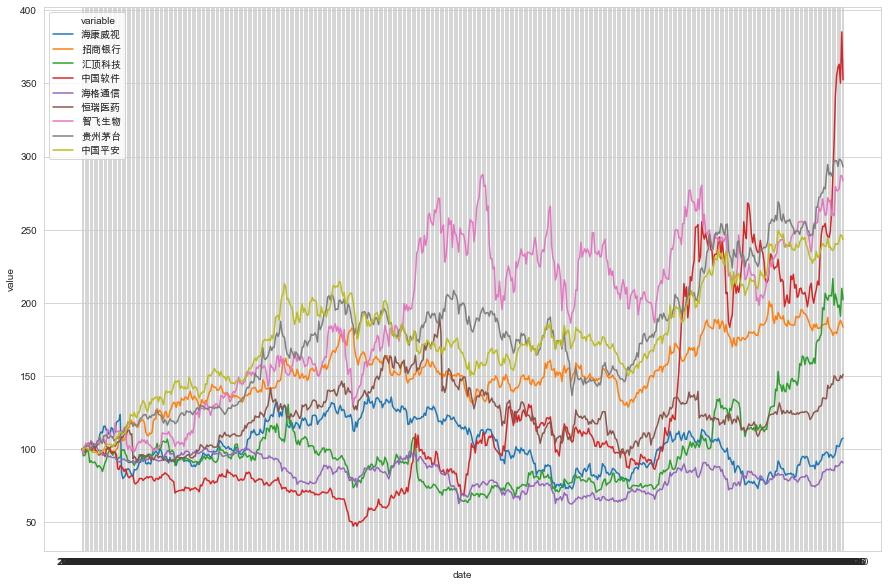

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
%matplotlib inline

plt.rcParams['font.family'] = ['Arial Unicode MS']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.figure(figsize=(15, 10))
sns.set_style('whitegrid', {'font.sans-serif': ['Arial Unicode MS', 'Arial']})
fig = sns.lineplot(x='date', y='value', hue="variable", data=newdata_melted)

plt.savefig('tmp.pdf', bbox_inches='tight')
plt.show()

## 计算不同股票的均值、协方差
每年有252个交易日，用每日收益率乘以252得到年华收益率。现在需要计算每只股票的收益率，在金融领域中我们一般使用对数收益率。这里体现了pandas的强大，df.pct_change()直接就能得到股票收益率

In [49]:
import numpy as np
log_returns = np.log(newdata.pct_change()+1)
log_returns = log_returns.dropna()
log_returns.mean()*252

海康威视    0.030144
招商银行    0.255449
汇顶科技    0.296591
中国软件    0.530882
海格通信   -0.041795
恒瑞医药    0.173725
智飞生物    0.439102
贵州茅台    0.452919
中国平安    0.374466
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2454e2e8>,
      dtype=object)

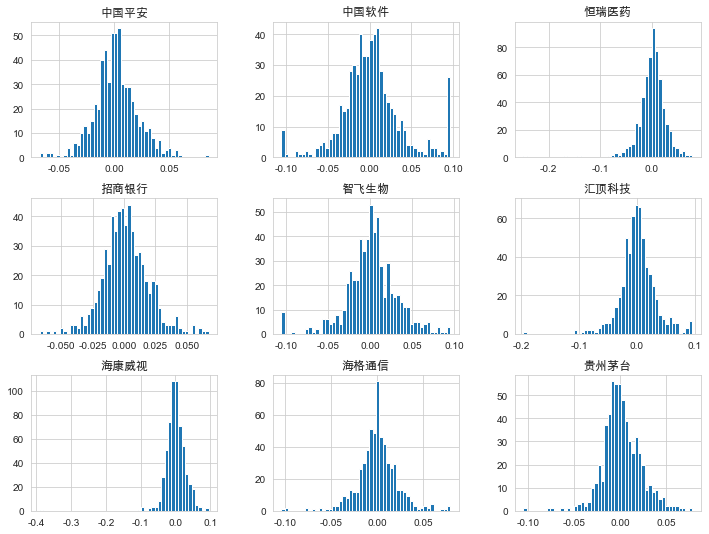

In [50]:
#画出每只股票收益率的直方图，了解一下分布情况。
%matplotlib inline
log_returns.hist(bins=50, figsize=(12, 9))

马科维茨的投资组合理论需要满足收益率符合正态分布，scipy.stats库为我们提供了正态性测试函数

-scipy.stats.normaltest 测试样本是否与正态分布不同，返回p值。

In [51]:
import scipy.stats as scs
stocks = list(data.columns)

def normality_test(array):
    print('Norm test p-value %14.3f' % scs.normaltest(array)[1])

for stock in stocks:
    print('\nResults for {}'.format(stock))
    print('-'*32)
    log_data = np.array(log_returns[stock])
    normality_test(log_data)


Results for 海康威视
--------------------------------
Norm test p-value          0.000

Results for 招商银行
--------------------------------
Norm test p-value          0.000

Results for 汇顶科技
--------------------------------
Norm test p-value          0.000

Results for 中国软件
--------------------------------
Norm test p-value          0.000

Results for 海格通信
--------------------------------
Norm test p-value          0.000

Results for 恒瑞医药
--------------------------------
Norm test p-value          0.000

Results for 智飞生物
--------------------------------
Norm test p-value          0.000

Results for 贵州茅台
--------------------------------
Norm test p-value          0.000

Results for 中国平安
--------------------------------
Norm test p-value          0.000


## 投资组合预期收益率、波动率
我们先随机生成一维投资组合权重向量（长度为9，与股票数量相等），因为中国股市的不允许卖空，所以投资组合权重向量中的数值必须在0到1之间。

In [52]:
weights = np.random.random(9)
weights /= np.sum(weights)
print(weights)
#投资组合预期收益率等于每只股票的权重与其对应股票的年化收益率的乘积
print(np.dot(weights, log_returns.mean())*252)
#投资组合波动率（方差）
print(np.dot(weights, np.dot(log_returns.cov()*252, weights)))
#投资组合收益的年化风险（标准差）
print(np.sqrt(np.dot(weights, np.dot(log_returns.cov()*252, weights))))

[0.05600667 0.21312024 0.06232615 0.20281261 0.14675367 0.10953508
 0.05138951 0.15574956 0.00230651]
0.2891508287106167
0.06270673029240789
0.2504131192497867


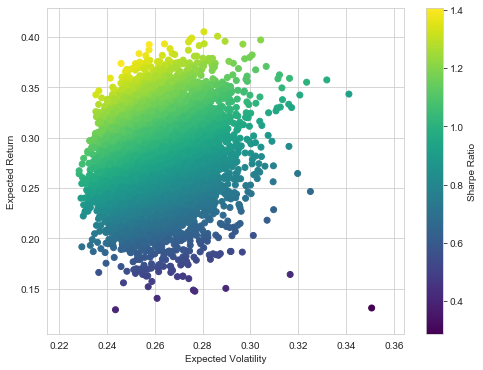

In [64]:
# 生成1000种随机的投资组合，即权重weights的尺寸为（1000*9）。
import matplotlib.pyplot as plt
%matplotlib inline

cm = plt.cm.get_cmap('viridis')
port_returns = []
port_variance = []
for p in range(10000):
    weights = np.random.random(9)
    weights /= np.sum(weights)
    port_returns.append(np.sum(log_returns.mean()*252*weights))
    port_variance.append(
        np.sqrt(np.dot(weights.T, np.dot(log_returns.cov()*252, weights))))

port_returns = np.array(port_returns)
port_variance = np.array(port_variance)

# 无风险利率设定为3%
risk_free = 0.03
plt.figure(figsize=(8, 6))
plt.scatter(port_variance, port_returns, c=(
    port_returns-risk_free)/port_variance, marker='o',cmap=cm)
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')

## 投资组合优化1—夏普率最大
建立stats函数来记录重要的投资组合统计数据（收益，方差和夏普比）。scipy.optimize可以提供给我们最小优化算法，而最大化夏普率可以转化为最小化负的夏普率。

In [57]:
import scipy.optimize as sco


def stats(weights):
    weights = np.array(weights)
    port_returns = np.sum(log_returns.mean()*weights)*252
    port_variance = np.sqrt(
        np.dot(weights.T, np.dot(log_returns.cov()*252, weights)))
    return np.array([port_returns, port_variance, port_returns/port_variance])

# 最小化夏普指数的负值


def min_sharpe(weights):
    return -stats(weights)[2]


# 给定初始权重
x0 = 9*[1./9]

# 权重（某股票持仓比例）限制在0和1之间。
bnds = tuple((0, 1) for x in range(9))

# 权重（股票持仓比例）的总和为1。
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})

# 优化函数调用中忽略的唯一输入是起始参数列表(对权重的初始猜测)。我们简单的使用平均分布。
opts = sco.minimize(min_sharpe,
                    x0,
                    method='SLSQP',
                    bounds=bnds,
                    constraints=cons)
print(opts)
df=pd.DataFrame(stocks,columns=['name'])
df['权重']=pd.DataFrame(opts['x'].round(3))
print(df)
stats(opts['x']).round(3)

     fun: -1.654206564220866
     jac: array([ 1.40515804e+00, -2.83598900e-04, -2.26929784e-04,  3.65078449e-06,
        1.18239784e+00,  7.58927509e-01, -9.60081816e-05, -7.86334276e-05,
        2.69234180e-04])
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([1.00787528e-15, 5.23927519e-02, 1.53509042e-02, 1.68120090e-01,
       0.00000000e+00, 1.81030939e-16, 1.19590559e-01, 4.14914013e-01,
       2.29631682e-01])
   name     权重
0  海康威视  0.000
1  招商银行  0.052
2  汇顶科技  0.015
3  中国软件  0.168
4  海格通信  0.000
5  恒瑞医药  0.000
6  智飞生物  0.120
7  贵州茅台  0.415
8  中国平安  0.230


array([0.434, 0.262, 1.654])

## 投资组合优化-方差最小

In [58]:
#但是我们定义一个函数对 方差进行最小化
def min_variance(weights):
    return stats(weights)[1]

optv = sco.minimize(min_variance, 
                    x0, 
                    method = 'SLSQP', 
                    bounds = bnds, 
                    constraints = cons)
print(optv)
df=pd.DataFrame(stocks,columns=['name'])
df['权重']=pd.DataFrame(optv['x'].round(3))
print(df)
stats(optv['x'].round(3))

     fun: 0.22138600558839533
     jac: array([0.23198296, 0.22152414, 0.22137308, 0.22148128, 0.22113243,
       0.22146801, 0.22131349, 0.22136825, 0.22332158])
 message: 'Optimization terminated successfully.'
    nfev: 121
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([2.91289330e-18, 4.35105769e-01, 7.21322252e-02, 2.80941037e-02,
       2.35151937e-01, 4.70646561e-02, 5.17625361e-02, 1.30688773e-01,
       0.00000000e+00])
   name     权重
0  海康威视  0.000
1  招商银行  0.435
2  汇顶科技  0.072
3  中国软件  0.028
4  海格通信  0.235
5  恒瑞医药  0.047
6  智飞生物  0.052
7  贵州茅台  0.131
8  中国平安  0.000


array([0.22784833, 0.22138606, 1.02919008])

## 资产组合的有效边界
有效边界是由一系列既定的目标收益率下方差最小的投资组合点组成的。在最优化时采用两个约束，
1. 给定目标收益率，
2. 投资组合权重和为1。

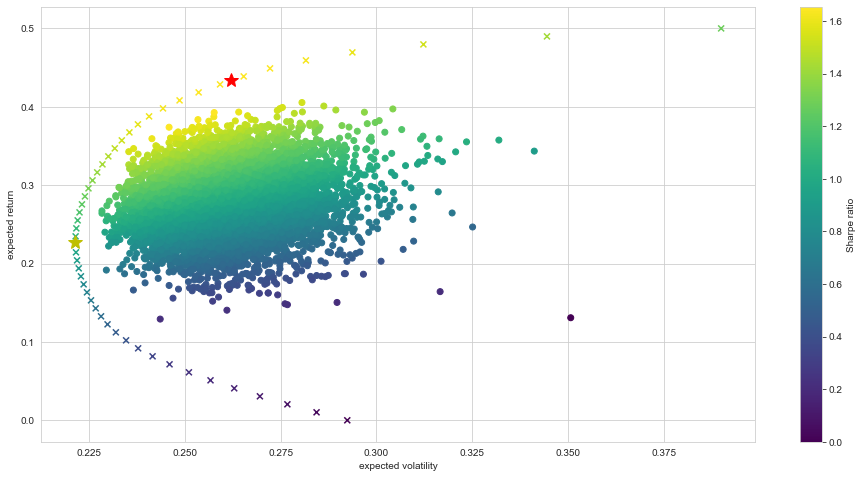

In [65]:
def min_variance(weights):
    return stats(weights)[1]


# 在不同目标收益率水平（target_returns）循环时，最小化的一个约束条件会变化。
target_returns = np.linspace(0.0, 0.5, 50)
target_variance = []
for tar in target_returns:
    # 给定限制条件：给定收益率、投资组合权重之和为1
    cons = ({'type': 'eq', 'fun': lambda x: stats(x)[0]-tar}, #限定收益率
            {'type': 'eq', 'fun': lambda x: np.sum(x)-1})
    res = sco.minimize(min_variance, x0, method='SLSQP',
                       bounds=bnds, constraints=cons)
    target_variance.append(res['fun'])

target_variance = np.array(target_variance)

plt.figure(figsize=(16, 8))
# 圆点：随机生成的投资组合散布的点
plt.scatter(port_variance, port_returns,
            c=port_returns/port_variance, marker='o',cmap=cm)
# 叉号：投资组合有效边界
plt.scatter(target_variance, target_returns,
            c=target_returns/target_variance, marker='x',cmap=cm)
# 红星：标记夏普率最大的组合点
plt.plot(stats(opts['x'])[1], stats(opts['x'])[0], 'r*', markersize=15.0)
# 黄星：标记方差最小投资组合点
plt.plot(stats(optv['x'])[1], stats(optv['x'])[0], 'y*', markersize=15.0)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

从黄色五角星到红色五角星是投资最有效的组合，这一系列的点所组成的边界就叫做 **投资有效边界** 。这条边界的特点是同样的风险的情况下获得的收益最大，同样的收益水平风险是最小的。从这条边界也印证了风险与收益成正比，要想更高的收益率就请承担更大的风险，但如果落在投资有效边界上，性价比最高。